In [611]:
import pandas as pd
import numpy as np
import requests
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
import time
from nltk.tokenize import word_tokenize
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.pipeline import Pipeline

In this project, I will build a classification model that will predict whether a reddit post, with only the title and text content provided, is in the World of Warcraft (WoW) subreddit or the Final Fantasy XIV (FFXIV) subreddit.  
I am approaching the problem from the perspective of part of the marketing team at Square Enix, the publisher of FFXIV.  With this model, we may uncover language that our players use more frequently than those who enjoy our prime competitor, so we can better craft our marketing to appeal to our customers.

# Pushshift scraping!

The first thing we need is to use pushshift to grab our posts.  I built a function to grab 100 posts from every month from each subreddit, going back to the founding of the FFXIV subreddit (which, oddly enough, happens to be 10 years ago almost to the day!)

In [612]:
def posts_getter(subreddit):
    #using https://www.epochconverter.com/ I converted the current date 
    #and dates of the FFXI subreddit's founding (ffxiv is younger, so this way we'll have a more equal split)
    current_epoch = 1611872155
    founding_epoch = 1454019344
    one_month_in_seconds = 2628288
    url = 'https://api.pushshift.io/reddit/search/submission'
    posts = []
    #iterates, month by month, from the founding of the r/ffxiv to january 28, 2021, pulling 100 posts every month.
    #this spread of time helps ensure that there are no duplicate posts, and also gives us a very wide view of each subreddit
    time.sleep(15)
    for month in range(founding_epoch, current_epoch, one_month_in_seconds):
        res = requests.get(url, {'subreddit': subreddit, 'size': 100, 'before': month})
        try:
            data = res.json()
            posts.extend(data['data'])
        except:
            pass
    return posts
#gets the posts
ffxiv_posts = posts_getter('ffxiv')
wow_posts = posts_getter('wow')
#turns those posts into a dataframe
ffxiv_df = pd.DataFrame(ffxiv_posts)
wow_df = pd.DataFrame(wow_posts)
print('ffxiv shape is',ffxiv_df.shape)
print('wow shape is ',wow_df.shape)

ffxiv shape is (5900, 104)
wow shape is  (6100, 100)


We now have our two dataframes! Let's put them together!  I don't need to fret over differences in columns, since we only need three columns from them anyways.

In [613]:
df = pd.concat([ffxiv_df, wow_df], axis = 0)

Normally, I'd leave the below uncommented in order to save the dataframe.  However, I'm commenting it out to make sure I'm calling the same dataframe that I created on Saturday, January 30th.  This keeps my modeling consistent day to day.  If I were to take this into production, I would remove this comment (and a similar comment below that does the same thing once the dataset is clean.)

In [614]:
#df.to_csv('./datasets/concatenated_df.csv', index = False)

df = pd.read_csv('./datasets/concatenated_df.csv')

# Cleaning, tokenizing, and analyzing

Now, I'm turning my subreddit column into a numeric, and renaming it to reflect that.  I could have used get_dummies here as well, but decided to use this method as it makes certain that FFXIV is my positive value.  (This is merely a matter of taste:  I'm an avid FFXIV player.)

In [616]:
df['subreddit'].replace(['ffxiv','wow'],[1,0], inplace = True)
df.rename(columns = {'subreddit':'is_on_ffxiv'}, inplace = True)

Let's do some preliminary cleanings.  First, any null 'selftext' values will be the result of that post being something other than a self text post, such as an image, link, or video.  Thus, I'm replacing those nulls with 'notatextpost', with that string serving as an indicator, and something we can drop later once count vectorization is done.

In [617]:
df.loc[lambda df: df['selftext'].isna() == True] = df.loc[lambda df: df['selftext'].isna() == True].fillna('notatextpost')
print(df['selftext'].isna().sum())

0


Next, I separate the three columns I really need: my features and my target.

In [618]:
df = df[['selftext','title', 'is_on_ffxiv']]

In [619]:
df.isna().sum()

selftext       0
title          0
is_on_ffxiv    0
dtype: int64

In [620]:
df.shape

(12000, 3)

Looks good!  One more cleaning step:  dropping rows where the text was either deleted or removed:  We don't need to see what deleted posts have to say, and we also don't want to include any posts that were removed by a subreddit moderator, as that could lead to spam entering our dataset.

In [621]:
#dropping the rows where the post was removed, by a mod (removed) or the user (deleted).  Doesn't really offer us any good information, and could even give us spam posts that the mods removed.
df.drop(df.loc[lambda df: df['selftext'] == '[removed]'].index, inplace = True)
df.drop(df.loc[lambda df: df['selftext'] == '[deleted]'].index, inplace = True)

Next, in order to get my data ready to model, I use the Snowball Stemmer to get stems of every word in my text posts and my titles.  I chose Snowball Stemmer specifically because of it's language support, and the fact that I can tell it to ignore stop words, which results in a faster runtime.  Those stopwords will get dropped later by CountVectorizer, anyways. This will help save on computational expenses later on as well, since I'll have fewer features from my CountVectorizer.   

In [622]:
#first, tokenize both 'selftext' and 'title' in order to prep them for stemming
def identify_selftext_tokens(row):
    text = row['selftext']
    tokens = word_tokenize(text)
    token_words = [w for w in tokens if w.isalpha()]
    return token_words
def identify_title_tokens(row):
    text = row['title']
    tokens = word_tokenize(text)
    token_words = [w for w in tokens if w.isalpha()]
    return token_words

df['self_text_words'] = df.apply(identify_selftext_tokens, axis = 1)
df['title_words'] = df.apply(identify_title_tokens, axis = 1)

df['stemmed_self_text'] = df['self_text_words'].apply(lambda x: [SnowballStemmer("english", ignore_stopwords=True).stem(y) for y in x])
df['stemmed_title'] = df['title_words'].apply(lambda x: [SnowballStemmer("english", ignore_stopwords=True).stem(y) for y in x])

While I'm at it, I also created columns for post length and title length.  This may be nothing, but it's a feature worth investigating.

In [623]:
df['self_text_len'] = df['selftext'].apply(lambda x: len(x.split()))
df['title_len'] = df['title'].apply(lambda x: len(x.split()))

Finally, I use the vader Sentiment Intensity Analyser to analyze both my titles and my self text.

In [624]:
analyzer = SentimentIntensityAnalyzer()
#self text first
df['self_text_vader_neg'] = 0
df['self_text_vader_pos'] = 0
df['self_text_vader_neu'] = 0
df['self_text_vader_compound'] = 0
for i, q in enumerate(df.selftext.values):
    vs = analyzer.polarity_scores(q)
    df.iloc[i, -4] = vs['neg']
    df.iloc[i, -3] = vs['pos']
    df.iloc[i, -2] = vs['neu']
    df.iloc[i, -1] = vs['compound']
#now titles
df['title_vader_neg'] = 0
df['title_vader_pos'] = 0
df['title_vader_neu'] = 0
df['title_vader_compound'] = 0
for i, q in enumerate(df.title.values):
    vs = analyzer.polarity_scores(q)
    df.iloc[i, -4] = vs['neg']
    df.iloc[i, -3] = vs['pos']
    df.iloc[i, -2] = vs['neu']
    df.iloc[i, -1] = vs['compound']

Now, once my stemming, SA, and lengths have all been taken care of, I get rid of the columns I don't need.

In [625]:
df.drop(columns = ['selftext','title','self_text_words','title_words'], inplace = True)

In [626]:
#one last check to make sure our dataframe looks how we want it to
df.head()

,is_on_ffxiv,stemmed_self_text,stemmed_title,self_text_len,title_len,self_text_vader_neg,self_text_vader_pos,self_text_vader_neu,self_text_vader_compound,title_vader_neg,title_vader_pos,title_vader_neu,title_vader_compound
0,1,[notatextpost],"[post, your, favourit, screenshot]",1,4,0.0,0.0,1.0,0.0,0.000,0.000,1.000,0.0000
3,1,[notatextpost],"[have, drawn, anyth, in, like, a, decad, pick,...",1,21,0.0,0.0,1.0,0.0,0.066,0.207,0.727,0.5431
4,1,[notatextpost],"[what, are, the, chanc, the, fate, of, this, n...",1,13,0.0,0.0,1.0,0.0,0.000,0.130,0.870,0.2023
5,1,"[so, a, few, week, ago, there, was, a, new, su...","[ffxiv, survey, realm, pop, etc, look, for]",49,6,0.0,0.0,1.0,0.0,0.000,0.000,1.000,0.0000
6,1,[notatextpost],"[drew, my, pld, and, lalafel, smn]",1,7,0.0,0.0,1.0,0.0,0.000,0.000,1.000,0.0000


It's clean, stemmed, analyzed, and I've got some extra features to work with.  Let's save it to a csv, for consistency.

In [627]:
#df.to_csv('./datasets/stemmed_and_cleaned_df.csv', index = False)

df = pd.read_csv('./datasets/stemmed_and_cleaned_df.csv')

## EDA Visualizations & Feature Engineering

Let's begin the EDA with some basic summary statistics.  We've only got two numeric columns, so let's see what they have to say.

In [628]:
df['self_text_len'].describe()

count    10473.000000
mean        61.292753
std        129.307358
min          1.000000
25%          1.000000
50%         27.000000
75%         75.000000
max       4487.000000
Name: self_text_len, dtype: float64

A high average for post length, and a very high standard deviation.  I suspect that maximum of 4000 is pulling the mean and std higher than they ought to be.

In [629]:
df['title_len'].describe()

count    10473.000000
mean         8.719660
std          6.206352
min          1.000000
25%          5.000000
50%          7.000000
75%         11.000000
max         63.000000
Name: title_len, dtype: float64

While the standard deviation isn't as out of proportion as it is in self-text, there remains a significant outlier in the titles.  Hopefully, I'll see what that's about by examining the distributions.

First, let's see the distributions of our self text lengths and our title lengths.  I'll do one table that includes both subs, and then one table for each of them.

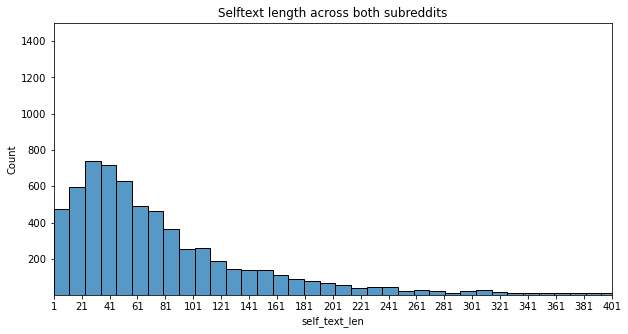

In [630]:
plt.figure(figsize=(10,5))
plt.xlim(1, 400)
plt.ylim(1,1500)
plt.xticks(range(1,420,20))
#exclude all 'notatextpost' and 'deleted' values
plt.title('Selftext length across both subreddits')
sns.histplot(df.loc[df['stemmed_self_text'] != "['notatextpost']"]['self_text_len'], bins = 400);

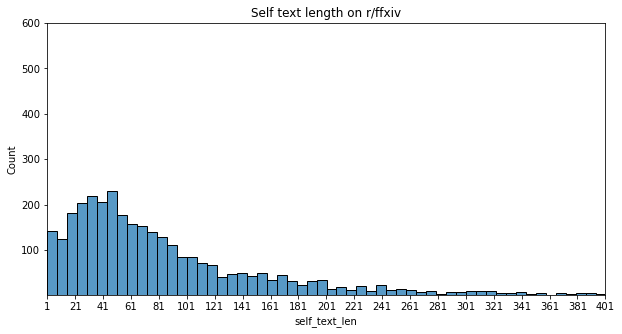

In [631]:
plt.figure(figsize = (10,5))
plt.xlim(1, 400)
plt.ylim(1,600)
plt.xticks(range(1,420,20))
#exclude all 'notatextpost' and 'deleted' values
plt.title('Self text length on r/ffxiv')
sns.histplot(df.loc[df['stemmed_self_text'] != "['notatextpost']"].loc[df['is_on_ffxiv'] == 1]['self_text_len'], bins = 400);

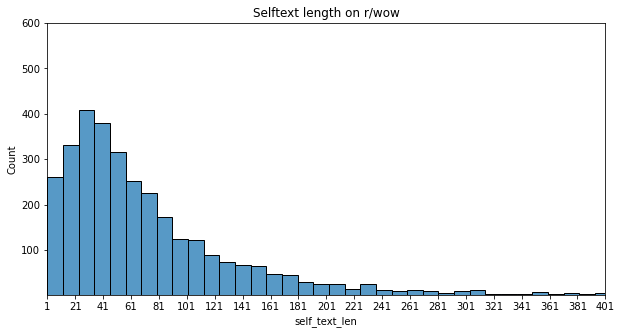

In [632]:
plt.figure(figsize = (10,5))
plt.xlim(1, 400)
plt.ylim(1,600)
plt.xticks(range(1,420,20))
#exclude all 'notatextpost' and 'deleted' values
plt.title('Selftext length on r/wow')
sns.histplot(df.loc[df['stemmed_self_text'] != "['notatextpost']"].loc[df['is_on_ffxiv'] == 0]['self_text_len'], bins = 400);

Many posts with just less than ten words here.  Even after removing deleted, mod-removed, and non-text posts, there's still very many.  A surprising statistic, and it is consistent across both subreddits.   Beyond that, though, the distributions are very similar to eachother.

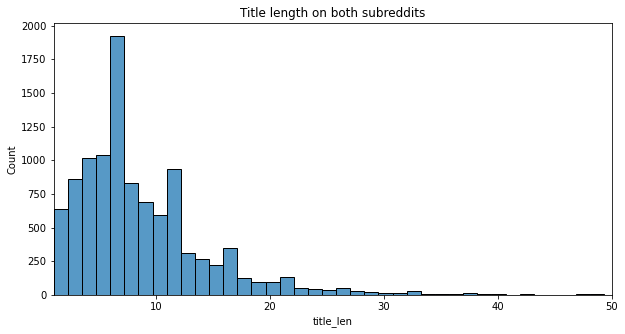

In [633]:
plt.figure(figsize = (10,5))
plt.xlim(1, 50)
plt.title('Title length on both subreddits')
sns.histplot(df['title_len'], bins = 50);

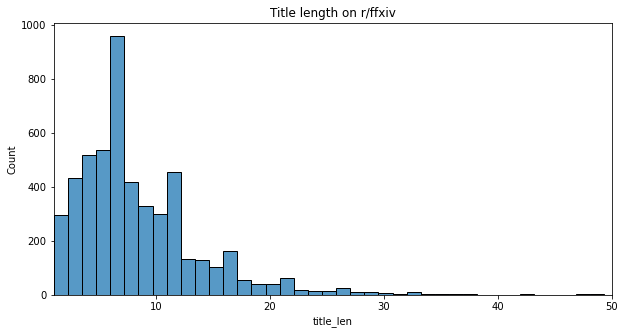

In [634]:
plt.figure(figsize = (10,5))
plt.xlim(1, 50)
plt.title('Title length on r/ffxiv')
sns.histplot(df.loc[df['is_on_ffxiv'] == 1]['title_len'], bins = 50);

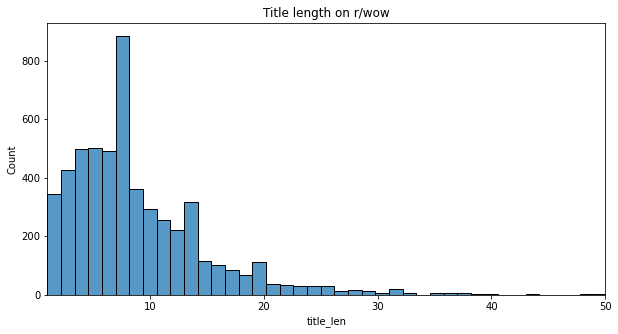

In [635]:
plt.figure(figsize = (10,5))
plt.xlim(1, 50)
plt.title('Title length on r/wow')
sns.histplot(df.loc[df['is_on_ffxiv'] == 0]['title_len'], bins = 50);

Again, these features are almost identical in distribution.  With this information, I'm considering dropping these columns.

Next, I'll examine some box plots to get a better look at those outliers.

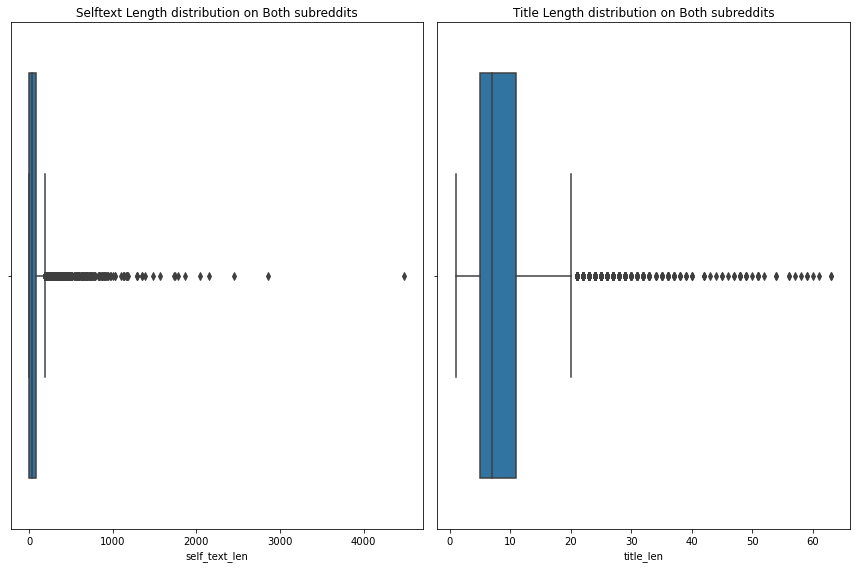

In [636]:
plt.subplot(121)
#plt.figure(figsize = (10,5))
plt.title('Selftext Length distribution on Both subreddits')
sns.boxplot(x= df['self_text_len'])
plt.subplot(122)
plt.title('Title Length distribution on Both subreddits')
sns.boxplot(x= df['title_len'])
plt.tight_layout(rect=(8,8,10,10))

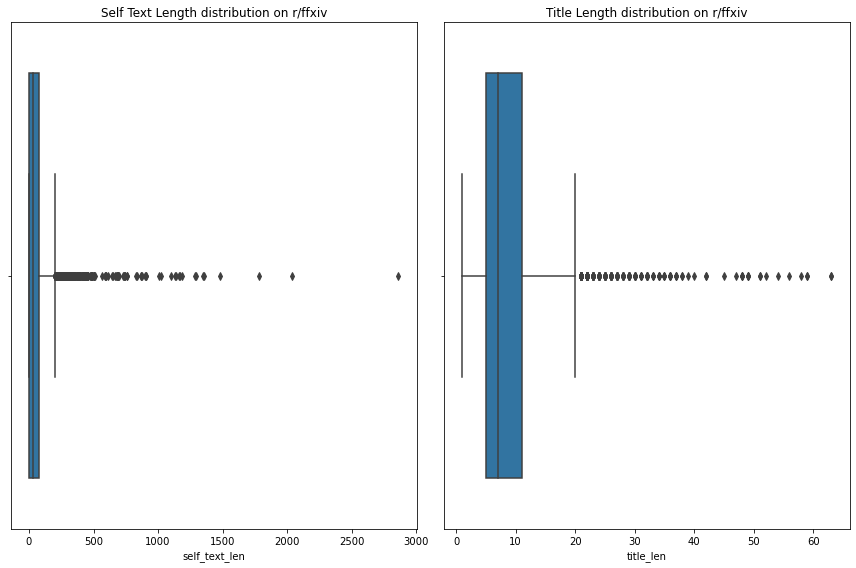

In [637]:
plt.subplot(121)
plt.title('Self Text Length distribution on r/ffxiv')
sns.boxplot(x= df.loc[df['is_on_ffxiv'] == 1]['self_text_len'])
plt.subplot(122)
plt.title('Title Length distribution on r/ffxiv')
sns.boxplot(x= df.loc[df['is_on_ffxiv'] == 1]['title_len'])
plt.tight_layout(rect=(8,8,10,10))

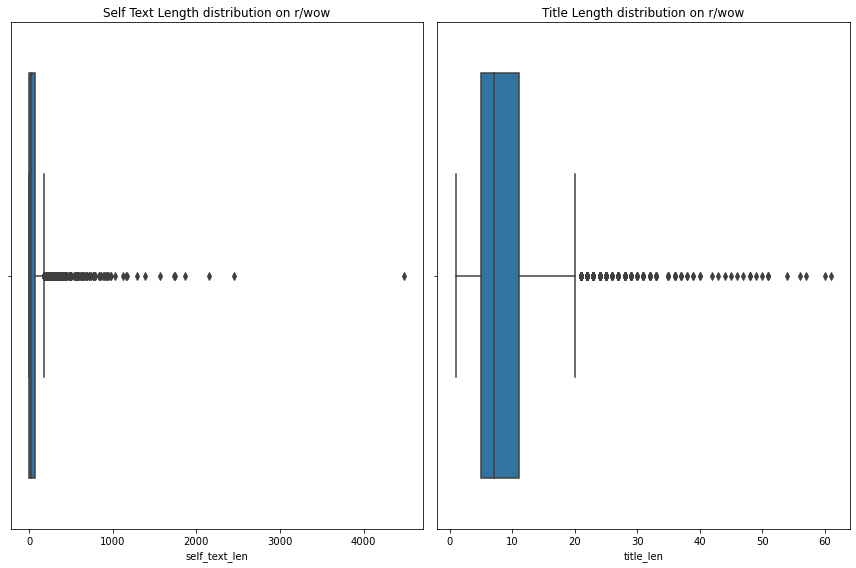

In [638]:
plt.subplot(121)
plt.title('Self Text Length distribution on r/wow')
sns.boxplot(x= df.loc[df['is_on_ffxiv'] == 0]['self_text_len'])
plt.subplot(122)
plt.title('Title Length distribution on r/wow')
sns.boxplot(x= df.loc[df['is_on_ffxiv'] == 0]['title_len'])
plt.tight_layout(rect=(8,8,10,10))

With these boxplots, we can better see the number of outliers in each distribution, and this data only further reinforces my plan to drop the length and title columns from our features.  If the two datasets have this much in common with eachother on these features, then these features will not be particularly useful in telling the two apart.

Next, I want to examine the distributions of all my Vader scores, both on the whole and on each subreddit.

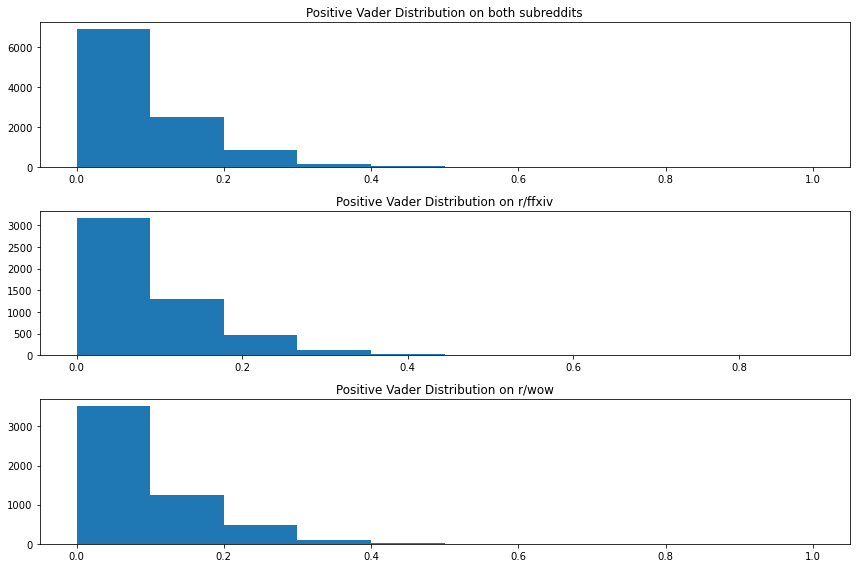

In [639]:
plt.subplot(311)
plt.title('Positive Vader Distribution on both subreddits')
plt.hist(df['self_text_vader_pos']);
plt.subplot(312)
plt.title('Positive Vader Distribution on r/ffxiv')
plt.hist(df.loc[df['is_on_ffxiv'] == 1]['self_text_vader_pos'])
plt.subplot(313)
plt.title('Positive Vader Distribution on r/wow')
plt.hist(df.loc[df['is_on_ffxiv'] == 0]['self_text_vader_pos'])
plt.tight_layout(rect = (2,2,4,4));

Much like before, very very similar distributions.

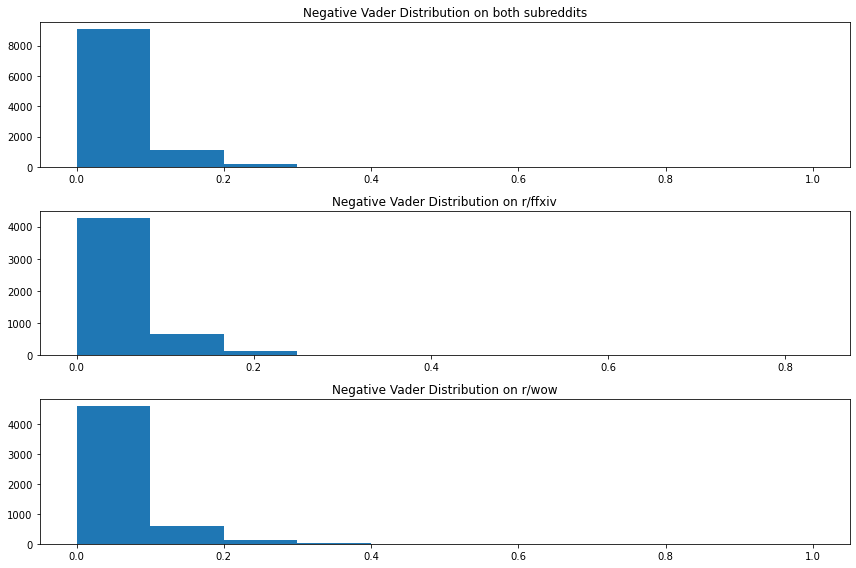

In [640]:
plt.subplot(311)
plt.title('Negative Vader Distribution on both subreddits')
plt.hist(df['self_text_vader_neg']);
plt.subplot(312)
plt.title('Negative Vader Distribution on r/ffxiv')
plt.hist(df.loc[df['is_on_ffxiv'] == 1]['self_text_vader_neg'])
plt.subplot(313)
plt.title('Negative Vader Distribution on r/wow')
plt.hist(df.loc[df['is_on_ffxiv'] == 0]['self_text_vader_neg'])
plt.tight_layout(rect = (2,2,4,4));

More of the same.

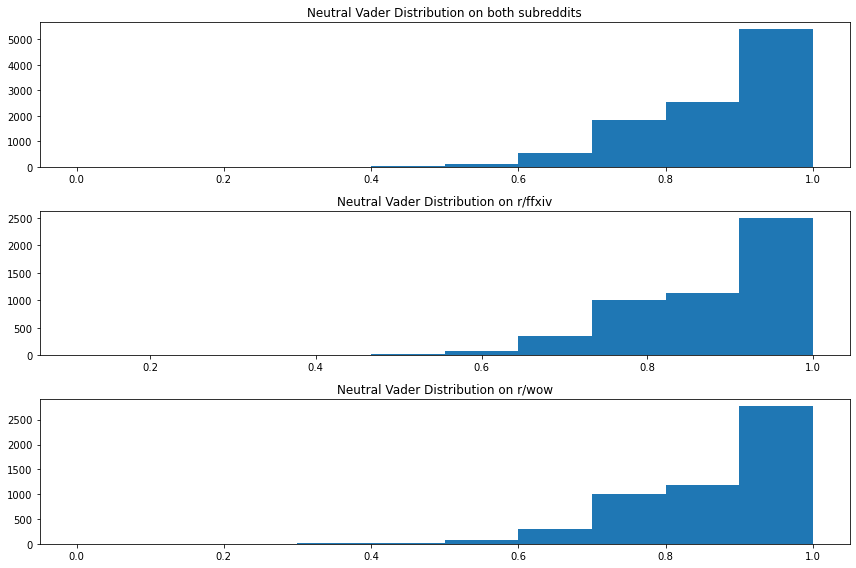

In [641]:
plt.subplot(311)
plt.title('Neutral Vader Distribution on both subreddits')
plt.hist(df['self_text_vader_neu']);
plt.subplot(312)
plt.title('Neutral Vader Distribution on r/ffxiv')
plt.hist(df.loc[df['is_on_ffxiv'] == 1]['self_text_vader_neu'])
plt.subplot(313)
plt.title('Neutral Vader Distribution on r/wow')
plt.hist(df.loc[df['is_on_ffxiv'] == 0]['self_text_vader_neu'])
plt.tight_layout(rect = (2,2,4,4));

And again, more of the same, but traveling in the other direction.

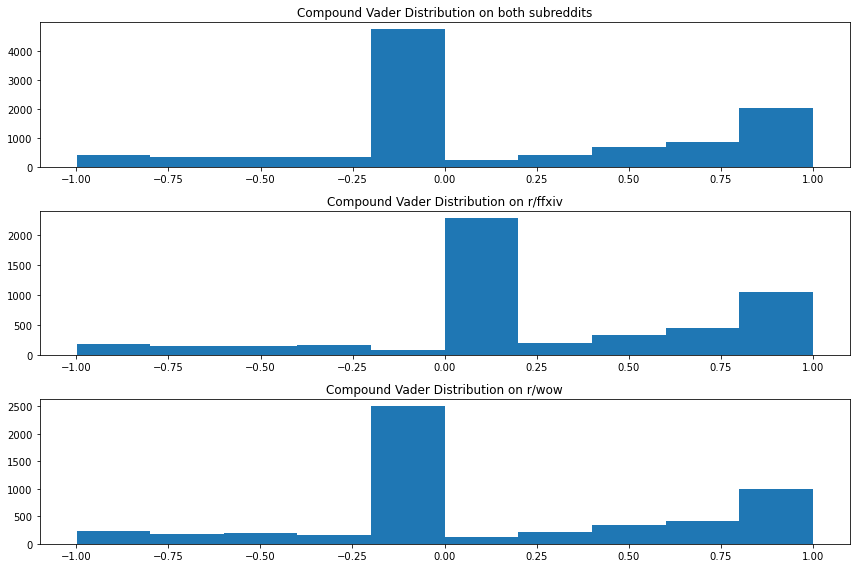

In [642]:
plt.subplot(311)
plt.title('Compound Vader Distribution on both subreddits')
plt.hist(df['self_text_vader_compound']);
plt.subplot(312)
plt.title('Compound Vader Distribution on r/ffxiv')
plt.hist(df.loc[df['is_on_ffxiv'] == 1]['self_text_vader_compound'])
plt.subplot(313)
plt.title('Compound Vader Distribution on r/wow')
plt.hist(df.loc[df['is_on_ffxiv'] == 0]['self_text_vader_compound'])
plt.tight_layout(rect = (2,2,4,4));

Here is where we can find the difference. The only distribution that seems to hold a significant difference is in the compound value.  I make note of that, and I will drop the other three when I'm done with my EDA.

Next, let's examine those distributions in our titles.

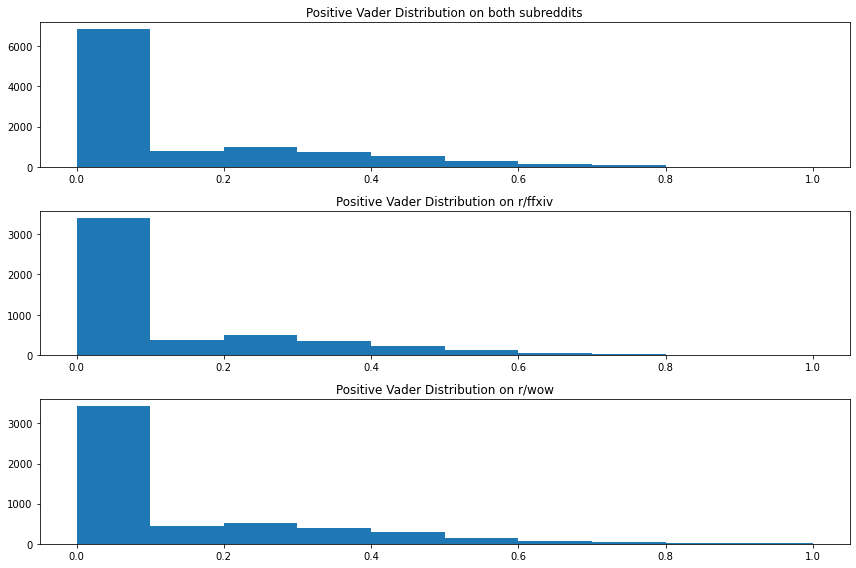

In [643]:
plt.subplot(311)
plt.title('Positive Vader Distribution on both subreddits')
plt.hist(df['title_vader_pos']);
plt.subplot(312)
plt.title('Positive Vader Distribution on r/ffxiv')
plt.hist(df.loc[df['is_on_ffxiv'] == 1]['title_vader_pos'])
plt.subplot(313)
plt.title('Positive Vader Distribution on r/wow')
plt.hist(df.loc[df['is_on_ffxiv'] == 0]['title_vader_pos'])
plt.tight_layout(rect = (2,2,4,4));

Same distributions again.

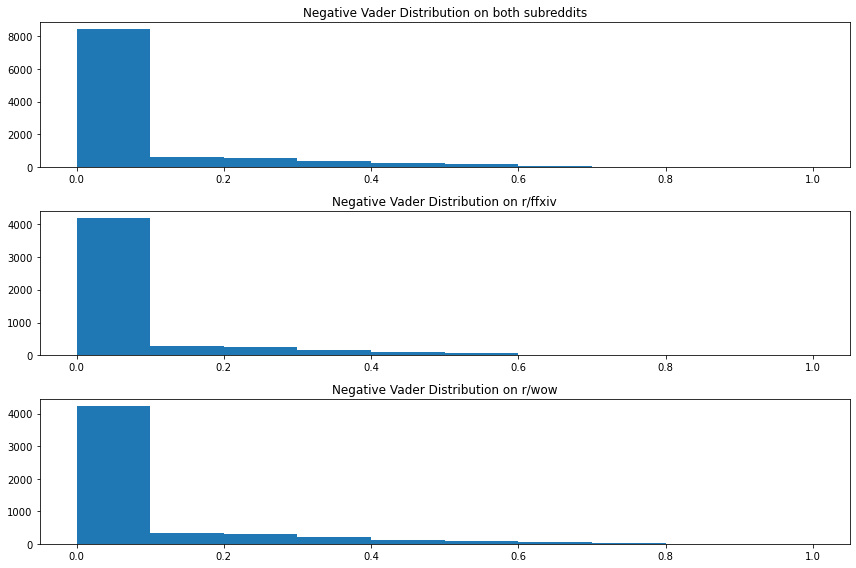

In [644]:
plt.subplot(311)
plt.title('Negative Vader Distribution on both subreddits')
plt.hist(df['title_vader_neg']);
plt.subplot(312)
plt.title('Negative Vader Distribution on r/ffxiv')
plt.hist(df.loc[df['is_on_ffxiv'] == 1]['title_vader_neg'])
plt.subplot(313)
plt.title('Negative Vader Distribution on r/wow')
plt.hist(df.loc[df['is_on_ffxiv'] == 0]['title_vader_neg'])
plt.tight_layout(rect = (2,2,4,4));

And again.

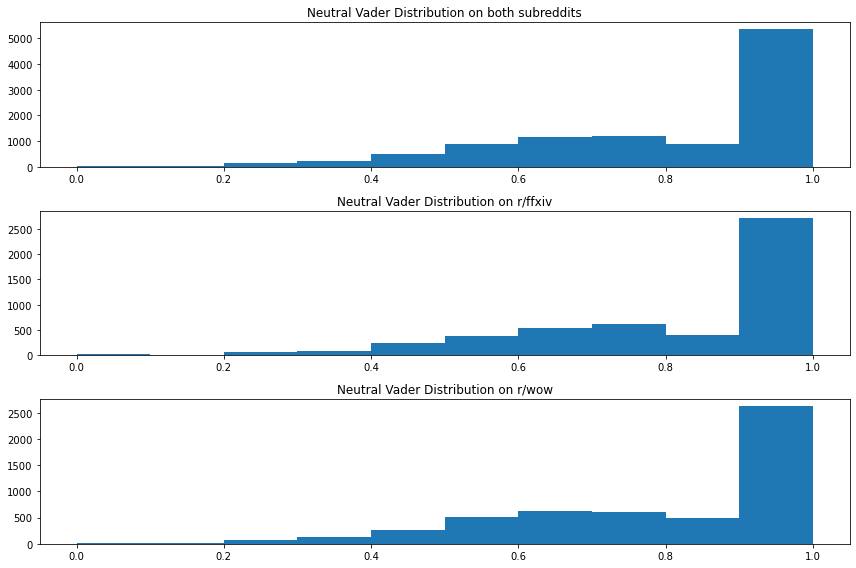

In [645]:
plt.subplot(311)
plt.title('Neutral Vader Distribution on both subreddits')
plt.hist(df['title_vader_neu']);
plt.subplot(312)
plt.title('Neutral Vader Distribution on r/ffxiv')
plt.hist(df.loc[df['is_on_ffxiv'] == 1]['title_vader_neu'])
plt.subplot(313)
plt.title('Neutral Vader Distribution on r/wow')
plt.hist(df.loc[df['is_on_ffxiv'] == 0]['title_vader_neu'])
plt.tight_layout(rect = (2,2,4,4));

And again.

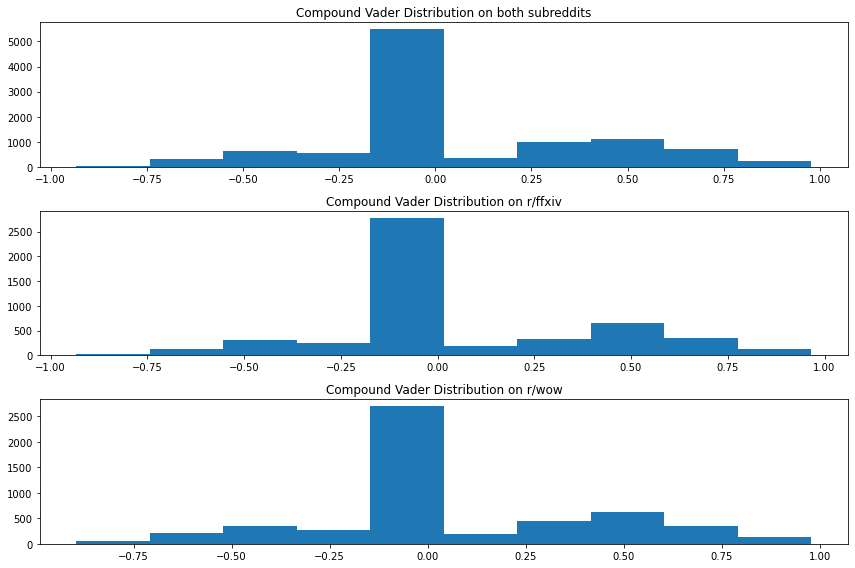

In [646]:
plt.subplot(311)
plt.title('Compound Vader Distribution on both subreddits')
plt.hist(df['title_vader_compound']);
plt.subplot(312)
plt.title('Compound Vader Distribution on r/ffxiv')
plt.hist(df.loc[df['is_on_ffxiv'] == 1]['title_vader_compound'])
plt.subplot(313)
plt.title('Compound Vader Distribution on r/wow')
plt.hist(df.loc[df['is_on_ffxiv'] == 0]['title_vader_compound'])
plt.tight_layout(rect = (2,2,4,4));

And again!  Somehow even the compound distributions are the same concerning our titles.  It appears that none of this data will make our model more effective, since none if it is indicative towards one class or the other.  I'll be dropping all these columns except for the Self Text Compound score, as there may still be some value in that feature.

In [647]:
df.drop(columns = [
    'self_text_len',
    'title_len',
    'self_text_vader_pos',
    'self_text_vader_neu',
    'self_text_vader_neg',
    'title_vader_pos',
    'title_vader_neg',
    'title_vader_neu',
    'title_vader_compound'], 
    inplace = True)

## Vectorizing and Modeling

My data is clean, I've pruned and tweaked my features, my words are ready for vectorization.  It's time to vectorize and model!  I want to get a look at what our model looks like with raw Count Vectorization AND TFIDF Vectorization, so I'll be setting up four models: two for my CVEC data, and two for TFIDF data.

In [648]:
#creates the Count Vectorized self text column
self_text_cvec = CountVectorizer(stop_words = 'english', min_df=3)
self_text_cvec.fit(df['stemmed_self_text'])
self_text_words = pd.DataFrame(self_text_cvec.transform(df['stemmed_self_text']).todense(),columns = self_text_cvec.get_feature_names())
#creates the Count Vectorized title column
title_cvec = CountVectorizer(stop_words = 'english')
title_cvec.fit(df['stemmed_title'])
title_words = pd.DataFrame(title_cvec.transform(df['stemmed_title']).todense(),columns = title_cvec.get_feature_names())
#pushes the two columns together
cvec_df = pd.concat([title_words, self_text_words, df.drop(columns = ['stemmed_self_text','stemmed_title'])], axis = 1)
#drop all the single word columns that don't provide value, such as chunks of urls and those pesky 'notatextpost' values
cvec_df.drop(columns = ['notatextpost', 'delet', 'http','titl', 'https','img', 'amp'], inplace = True)
#sums all the duplicate columns
cvec_df = cvec_df.sum(axis = 1, level = 0)
#let's set up pipelins so we can scale and fit at the same time
cvec_rf_pipe = Pipeline([('scaler', StandardScaler()),('ran_for', RandomForestClassifier())])
#now for splitting our data into test and train
cvec_X = cvec_df.drop(columns = 'is_on_ffxiv')
cvec_y = cvec_df['is_on_ffxiv']
cvec_X_train, cvec_X_test, cvec_y_train, cvec_y_test = train_test_split(cvec_X,cvec_y, random_state = 42)
#random forest first
cvec_rf_pipe.fit(cvec_X_train, cvec_y_train)
#baseline!  We can treat this baseline as accurate for both the CVEC and TVEC models, as the target is unmodified by the vectorization.
print('The baseline score for the data is:',1 - cvec_y.mean())
#printing our scores as we go, and I will compare them all when this cell is finished running.
print('The CVEC Random Forest training score is:', cvec_rf_pipe.score(cvec_X_train, cvec_y_train))
print('The CVEC Random Forest testing score is:', cvec_rf_pipe.score(cvec_X_test, cvec_y_test))
#now for the extra trees, scaler included
cvec_extra_pipe = Pipeline([('scaler', StandardScaler()),('extra_trees', ExtraTreesClassifier())])
cvec_extra_pipe.fit(cvec_X_train, cvec_y_train)
print('The CVEC Extra Trees training score is:', cvec_extra_pipe.score(cvec_X_train, cvec_y_train))
print('The CVEC Extra Trees testing score is:', cvec_extra_pipe.score(cvec_X_test, cvec_y_test))

#from here on out, it's the same sequence of events as above, just applied with TFIDF instead
self_text_tvec = TfidfVectorizer(stop_words = 'english',min_df = .01)
self_text_tvec.fit(df['stemmed_self_text'])
self_text_tvec_words = pd.DataFrame(self_text_tvec.transform(df['stemmed_self_text']).todense(),columns = self_text_tvec.get_feature_names())
title_tvec = TfidfVectorizer(stop_words = 'english')
title_tvec.fit(df['stemmed_title'])
title_tvec_words = pd.DataFrame(title_tvec.transform(df['stemmed_title']).todense(),columns = title_tvec.get_feature_names())
tvec_df = pd.concat([title_tvec_words, self_text_tvec_words, df.drop(columns = ['stemmed_self_text','stemmed_title'])], axis = 1)
tvec_df = tvec_df.sum(axis = 1, level = 0)
tvec_X = tvec_df.drop(columns = 'is_on_ffxiv')
tvec_y = tvec_df['is_on_ffxiv']
tvec_X_train, tvec_X_test, tvec_y_train, tvec_y_test = train_test_split(tvec_X,tvec_y, random_state = 42)
tvec_rf_pipe = Pipeline([('scaler', StandardScaler()),('ran_for', RandomForestClassifier())])
tvec_rf_pipe.fit(tvec_X_train, tvec_y_train)
print('The TVEC Random Forest training score is:', tvec_rf_pipe.score(tvec_X_train, tvec_y_train))
print('The TVEC Random Forest testing score is:', tvec_rf_pipe.score(tvec_X_test, tvec_y_test))
tvec_extra_pipe = Pipeline([('scaler', StandardScaler()),('ran_for', ExtraTreesClassifier())])
tvec_extra_pipe.fit(tvec_X_train, tvec_y_train)
print('The TVEC Extra Trees training score is:', tvec_extra_pipe.score(tvec_X_train, tvec_y_train))
print('The TVEC Extra Trees testing score is:', tvec_extra_pipe.score(tvec_X_test, tvec_y_test))

The baseline score for the data is: 0.5116967440084026
The CVEC Random Forest training score is: 0.9983447924624396
The CVEC Random Forest testing score is: 0.8365788468881252
The CVEC Extra Trees training score is: 0.9983447924624396
The CVEC Extra Trees testing score is: 0.861397479954181
The TVEC Random Forest training score is: 0.998472116119175
The TVEC Random Forest testing score is: 0.7926689576174112
The TVEC Extra Trees training score is: 0.998472116119175
The TVEC Extra Trees testing score is: 0.8243604429171439


Of all the models I've tested, the CVEC Extra Trees, performs the best.  I'll be using that from here on out.

Now that I have our classification model ready, let's take a look at the confusion matrix and classification metrics.

In [649]:
pred = cvec_extra_pipe.predict(cvec_X_test)

In [655]:
print(confusion_matrix(cvec_y_test, pred, normalize = 'true'))

[[0.87678437 0.12321563]
 [0.15450311 0.84549689]]


In [656]:
print(classification_report(cvec_y_test, pred))

              precision    recall  f1-score   support

         0.0       0.85      0.88      0.87      1331
         1.0       0.87      0.85      0.86      1288

    accuracy                           0.86      2619
   macro avg       0.86      0.86      0.86      2619
weighted avg       0.86      0.86      0.86      2619



As far as our predictions go, we can see that it predicts positive (posts from r/FFXIV) correctly 87% of the time, and predicts negative (posts from r/WOW) 84% of the time.  The sensitivity and specificity is also around 86% for each as well.  All in all, a pretty solid model.

As a last point, let's see what the most effective features are.  This will be where we can gain some real inference usage, if there's any to be gained.

In [657]:
importances = cvec_extra_pipe.named_steps['extra_trees'].feature_importances_
print("Feature ranking:")
indices = np.argsort(importances)[::-1]
for f in range(cvec_X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]), cvec_X.columns[indices[f]])
#got this code from the sklearn site: https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html

Feature ranking:
1. feature 6850 (0.020433) wow
2. feature 2151 (0.016370) ffxiv
3. feature 3364 (0.010680) legion
4. feature 636 (0.009137) blizzard
5. feature 2828 (0.007295) hord
6. feature 3151 (0.006795) job
7. feature 577 (0.005815) bfa
8. feature 5408 (0.005611) shadowland
9. feature 5326 (0.005371) se
10. feature 2098 (0.005195) fc
11. feature 6675 (0.004920) warcraft
12. feature 2723 (0.004549) heavensward
13. feature 1725 (0.004490) druid
14. feature 62 (0.004405) addon
15. feature 5403 (0.004164) shadowbring
16. feature 1040 (0.003984) classic
17. feature 2472 (0.003950) glamour
18. feature 5862 (0.003879) stormblood
19. feature 1127 (0.003854) commiss
20. feature 316 (0.003534) arr
21. feature 6899 (0.003527) xiv
22. feature 3992 (0.003513) mythic
23. feature 5417 (0.003500) shaman
24. feature 8397 (0.003440) self_text_vader_compound
25. feature 2881 (0.003310) hunter
26. feature 6303 (0.003176) transmog
27. feature 2373 (0.003145) game
28. feature 327 (0.002822) artifact
2

678. feature 5018 (0.000347) request
679. feature 2168 (0.000346) figur
680. feature 1850 (0.000346) emissari
681. feature 6164 (0.000345) thread
682. feature 329 (0.000345) artwork
683. feature 752 (0.000345) bring
684. feature 3810 (0.000344) min
685. feature 1911 (0.000344) epic
686. feature 4059 (0.000343) network
687. feature 1846 (0.000343) emerald
688. feature 3509 (0.000343) lost
689. feature 5937 (0.000342) suck
690. feature 3224 (0.000342) kick
691. feature 1999 (0.000342) expect
692. feature 278 (0.000341) arcan
693. feature 4341 (0.000341) pandaria
694. feature 4862 (0.000340) readi
695. feature 5818 (0.000340) stat
696. feature 3863 (0.000340) mob
697. feature 3501 (0.000340) lore
698. feature 4145 (0.000339) npcs
699. feature 4138 (0.000339) notic
700. feature 2095 (0.000339) favorit
701. feature 6419 (0.000339) unaccept
702. feature 3044 (0.000339) instant
703. feature 4900 (0.000338) recommend
704. feature 4672 (0.000338) progress
705. feature 2263 (0.000337) forgot
706

1428. feature 2969 (0.000141) imposs
1429. feature 486 (0.000140) ban
1430. feature 409 (0.000140) auto
1431. feature 1282 (0.000140) creation
1432. feature 5363 (0.000140) sent
1433. feature 1203 (0.000140) continu
1434. feature 2260 (0.000140) forget
1435. feature 5783 (0.000140) st
1436. feature 5263 (0.000140) saurfang
1437. feature 4303 (0.000140) overview
1438. feature 2585 (0.000140) ground
1439. feature 5057 (0.000139) restor
1440. feature 6767 (0.000139) wholesom
1441. feature 3887 (0.000139) mom
1442. feature 2651 (0.000139) hammer
1443. feature 1579 (0.000138) disc
1444. feature 4121 (0.000138) noob
1445. feature 2630 (0.000138) hack
1446. feature 2153 (0.000138) ffxivxnew
1447. feature 643 (0.000138) block
1448. feature 3052 (0.000138) intend
1449. feature 6688 (0.000138) warlord
1450. feature 4462 (0.000138) phone
1451. feature 4858 (0.000138) reaction
1452. feature 5304 (0.000138) scrapbook
1453. feature 7838 (0.000137) outdat
1454. feature 4414 (0.000137) pegasus
1455. f

2427. feature 5441 (0.000050) shed
2428. feature 6048 (0.000050) tankcob
2429. feature 428 (0.000050) await
2430. feature 7793 (0.000050) nero
2431. feature 5021 (0.000050) requiescat
2432. feature 5736 (0.000050) spiritbond
2433. feature 4646 (0.000050) priorit
2434. feature 904 (0.000050) caught
2435. feature 2014 (0.000049) express
2436. feature 4652 (0.000049) privat
2437. feature 7351 (0.000049) dozen
2438. feature 6315 (0.000049) trend
2439. feature 3746 (0.000049) merg
2440. feature 4620 (0.000049) prepatch
2441. feature 5377 (0.000049) seren
2442. feature 3330 (0.000049) lay
2443. feature 596 (0.000049) birdi
2444. feature 4397 (0.000049) pawn
2445. feature 6251 (0.000049) tool
2446. feature 6833 (0.000049) workin
2447. feature 6793 (0.000049) winter
2448. feature 4263 (0.000049) orphan
2449. feature 737 (0.000049) breathtak
2450. feature 630 (0.000049) blind
2451. feature 4723 (0.000049) pumpkin
2452. feature 785 (0.000049) built
2453. feature 6356 (0.000049) tune
2454. featur

3427. feature 2108 (0.000022) fee
3428. feature 4680 (0.000022) prompt
3429. feature 7437 (0.000022) facerol
3430. feature 3183 (0.000022) justic
3431. feature 4042 (0.000022) nemesi
3432. feature 963 (0.000022) cheaper
3433. feature 2803 (0.000022) hol
3434. feature 8251 (0.000022) tone
3435. feature 1765 (0.000022) dx
3436. feature 1650 (0.000022) domino
3437. feature 5995 (0.000022) sweat
3438. feature 1285 (0.000022) creatur
3439. feature 1150 (0.000022) compliment
3440. feature 6663 (0.000022) wallet
3441. feature 8054 (0.000022) savvi
3442. feature 6258 (0.000022) topsoil
3443. feature 693 (0.000022) boredom
3444. feature 6944 (0.000022) younger
3445. feature 5770 (0.000022) squad
3446. feature 5390 (0.000022) seventh
3447. feature 1657 (0.000022) doom
3448. feature 632 (0.000021) blitz
3449. feature 2206 (0.000021) flap
3450. feature 4621 (0.000021) preprepatch
3451. feature 4401 (0.000021) paysafecard
3452. feature 595 (0.000021) bird
3453. feature 456 (0.000021) babysitt
3454.

4177. feature 6358 (0.000013) turkey
4178. feature 3411 (0.000013) liev
4179. feature 8370 (0.000013) wire
4180. feature 7544 (0.000013) guilti
4181. feature 3415 (0.000013) lift
4182. feature 8064 (0.000013) screencap
4183. feature 1061 (0.000013) clockwork
4184. feature 7651 (0.000013) intrigu
4185. feature 5228 (0.000013) salti
4186. feature 3278 (0.000013) kyrian
4187. feature 734 (0.000013) breaker
4188. feature 2705 (0.000013) headset
4189. feature 7185 (0.000013) bummer
4190. feature 392 (0.000013) attribut
4191. feature 2557 (0.000013) graviti
4192. feature 7817 (0.000013) oath
4193. feature 6182 (0.000013) tick
4194. feature 2913 (0.000013) iconoclasm
4195. feature 8117 (0.000013) slime
4196. feature 1674 (0.000013) downsid
4197. feature 4166 (0.000013) observ
4198. feature 7208 (0.000013) chime
4199. feature 1295 (0.000013) crib
4200. feature 7739 (0.000013) mesh
4201. feature 7715 (0.000013) luster
4202. feature 7260 (0.000013) counterpart
4203. feature 1696 (0.000013) drdis

5177. feature 1333 (0.000006) cull
5178. feature 7660 (0.000006) ishgardian
5179. feature 2899 (0.000006) hypercharg
5180. feature 3497 (0.000006) looter
5181. feature 6208 (0.000006) tiqql
5182. feature 7487 (0.000006) freind
5183. feature 5071 (0.000006) retri
5184. feature 3172 (0.000006) jukebox
5185. feature 6614 (0.000006) vindicaar
5186. feature 1971 (0.000006) evga
5187. feature 4694 (0.000006) protest
5188. feature 8332 (0.000006) vod
5189. feature 1856 (0.000006) employe
5190. feature 7447 (0.000006) feather
5191. feature 6043 (0.000006) talon
5192. feature 6828 (0.000006) wore
5193. feature 5317 (0.000006) scrollbar
5194. feature 3727 (0.000006) memedisplac
5195. feature 7959 (0.000006) qarn
5196. feature 6233 (0.000006) toilet
5197. feature 8329 (0.000006) violet
5198. feature 7363 (0.000006) durotan
5199. feature 6440 (0.000006) underlight
5200. feature 8235 (0.000006) threw
5201. feature 7675 (0.000006) kidnap
5202. feature 5277 (0.000006) scandal
5203. feature 5039 (0.00

6176. feature 5081 (0.000003) revel
6177. feature 3363 (0.000003) leggo
6178. feature 2953 (0.000003) imaginari
6179. feature 7481 (0.000003) fraction
6180. feature 474 (0.000003) bagnon
6181. feature 8232 (0.000003) thorn
6182. feature 7147 (0.000003) bloodlett
6183. feature 5845 (0.000003) sting
6184. feature 7574 (0.000003) helio
6185. feature 7499 (0.000003) furthermor
6186. feature 5570 (0.000003) skipp
6187. feature 7082 (0.000003) armageddon
6188. feature 2081 (0.000003) fashionista
6189. feature 8156 (0.000003) squishi
6190. feature 2065 (0.000003) fanboy
6191. feature 39 (0.000003) acid
6192. feature 2391 (0.000003) garland
6193. feature 8192 (0.000003) suiton
6194. feature 8132 (0.000003) soil
6195. feature 7709 (0.000003) loyalti
6196. feature 2304 (0.000003) frenzi
6197. feature 2662 (0.000003) handwrap
6198. feature 2240 (0.000003) foil
6199. feature 4215 (0.000003) oln
6200. feature 3583 (0.000003) maintenc
6201. feature 8171 (0.000003) stomach
6202. feature 411 (0.000003

6926. feature 5974 (0.000000) surreal
6927. feature 5581 (0.000000) skychas
6928. feature 7386 (0.000000) embrac
6929. feature 3563 (0.000000) magani
6930. feature 6674 (0.000000) warcraflog
6931. feature 943 (0.000000) chans
6932. feature 3743 (0.000000) merch
6933. feature 8384 (0.000000) xpack
6934. feature 7072 (0.000000) approxim
6935. feature 4104 (0.000000) nobbel
6936. feature 3676 (0.000000) maut
6937. feature 5079 (0.000000) revantusk
6938. feature 2729 (0.000000) heed
6939. feature 8189 (0.000000) sucker
6940. feature 717 (0.000000) bozjan
6941. feature 5003 (0.000000) repgat
6942. feature 713 (0.000000) boxer
6943. feature 2239 (0.000000) foe
6944. feature 3222 (0.000000) khort
6945. feature 2316 (0.000000) frine
6946. feature 1394 (0.000000) darnedest
6947. feature 7692 (0.000000) lessen
6948. feature 6173 (0.000000) thul
6949. feature 7704 (0.000000) loath
6950. feature 7369 (0.000000) eb
6951. feature 1821 (0.000000) ellien
6952. feature 5708 (0.000000) specialspelltim
6

7926. feature 7518 (0.000000) glorifi
7927. feature 1712 (0.000000) drift
7928. feature 7538 (0.000000) grom
7929. feature 1718 (0.000000) drogbar
7930. feature 1719 (0.000000) drood
7931. feature 1721 (0.000000) dropdown
7932. feature 1722 (0.000000) droprat
7933. feature 7535 (0.000000) gripe
7934. feature 1728 (0.000000) drust
7935. feature 7526 (0.000000) grandma
7936. feature 1747 (0.000000) duncan
7937. feature 7524 (0.000000) gradual
7938. feature 1754 (0.000000) durid
7939. feature 1759 (0.000000) dvd
7940. feature 1762 (0.000000) dwarven
7941. feature 1840 (0.000000) embassi
7942. feature 7510 (0.000000) germani
7943. feature 7505 (0.000000) gaze
7944. feature 1789 (0.000000) ec
7945. feature 7502 (0.000000) gateway
7946. feature 7496 (0.000000) fuma
7947. feature 1803 (0.000000) egon
7948. feature 1804 (0.000000) ehhh
7949. feature 1806 (0.000000) eilex
7950. feature 1813 (0.000000) elereth
7951. feature 1824 (0.000000) elmo
7952. feature 1829 (0.000000) elunaria
7953. featur

And there we have it: the language that is most effective at discerning between the two subreddits is language that often deals with specific properties of the relevant games. 

Legion, BFA, and Shadowlands are all WOW Expansions, and Shadowlands and Stormblood are FFXIV expansions.  Mythic, classic, and guild are all heavily WOW-centric terms, while job, FC, and glamour are all FFXIV-centric.  Word-wise, it doesn't seem that NLP will tell us anything that a person with domain knowledge doesn't already know.

However, our one Vader Sentiment feature managed to crack in the top 25 features, which does show that it is a useful feature to keep around after all.  Perhaps that speaks to FFXIV's reputation as having a less toxic community than WOW, but I hesitate to call this absolute evidence of that.

Ultimately, this model could be useful for applying to a larger program that takes in post text and then decides whether the poster is a current player of FFXIV or a player of it's largest competitor, WOW, but this would only be efficient if the program were trying to work through reams of posts over a long time.  On a post by post basis, an individual with enough knowledge about either game would be just as accurate, if not more so.  The real benefit here would likely be speed.  In conclusion, I would not recommend the use of this model over individual post analysis, and I do not recommend it be used to try to match languge with users to seem more familiar to them.